# Dask for HPC: Parallel Computing with Dask on a Slurm Cluster

In this notebook, we will learn how to use Dask to scale up Python computations from a single machine to a multi-node Slurm cluster. We will start with a brief introduction to Dask and how to perform NumPy-like operations in parallel using Dask Arrays. Then, we'll explore how to launch and use a Dask distributed cluster on an HPC system with Slurm. Finally, we will look at using GPU accelerators with Dask (via CuPy) to further speed up computations. Throughout the tutorial, you'll find tasks/exercises to practice the concepts. By the end, you should understand how to harness Dask for large-scale parallel computing on an HPC cluster.

![Dask Slide](img/HPCP_Dask/Folie1.PNG)
![Dask Slide](img/HPCP_Dask/Folie2.PNG)
![Dask Slide](img/HPCP_Dask/Folie3.PNG)
![Dask Slide](img/HPCP_Dask/Folie4.PNG)

### Dask Basics: Parallelizing NumPy Operations with Dask Arrays

We begin with Dask's high-level Array API, which parallels NumPy. A Dask Array is composed of many small NumPy arrays (or possibly CuPy arrays, etc.) called chunks. These chunks can be processed in parallel, and Dask handles the coordination. The API for Dask Arrays is very similar to NumPy, which makes it easy to get started.

We will create some arrays using NumPy and Dask and see the difference:

In [8]:
import os
import socket
import math
import random
from time import sleep

import dask
import dask.array as da
import dask.dataframe as dd
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import numpy as np
import numba
import h5py

try:
    user_port = int(os.environ["USER"][-2:])
except ValueError:
    user_port = 55

In [3]:
# Create a large NumPy array and compute its mean
N = 10_000_000
np_array = np.random.random(N)
mean = np_array.mean()
mean

np.float64(0.49985239739667875)

In [4]:
%timeit np_array.mean()

8.18 ms ± 30.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
# Create a Dask array from the NumPy array, dividing it into chunks
chunk_size = 1_000_000 # 1 million elements per chunk (tweak as needed)
da_array = da.from_array(np_array, chunks=chunk_size)
print(da_array)  # this is a lazy Dask array, no computation yet

# Compute the mean using Dask
da_mean = da_array.mean().compute()  # triggers computation
print(da_mean)

dask.array<array, shape=(10000000,), dtype=float64, chunksize=(1000000,), chunktype=numpy.ndarray>
0.49985239739667886


In [6]:
%timeit da_array.mean().compute()

8.46 ms ± 65.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Did you notice that the computation took roughly the same time as with NumPy?  
This is not surprising: Dask is not designed to speed up very small computations.  

The real strength of Dask comes when:
- The data is too large to fit into memory on a single machine.
- You want to distribute computations across many cores or nodes.  

Since memory is such an important aspect, let’s now take a closer look at how Dask organizes its arrays into chunks. Each chunk is a NumPy array itself:

![Dask Array](img/dask_array.png)

In [7]:
da_array

dask.array<array, shape=(10000000,), dtype=float64, chunksize=(1000000,), chunktype=numpy.ndarray>

Choosing the right chunking strategy is crucial for good performance.  
The better you understand the structure of your data, the more intelligently you can define the chunks.  

And remember: your data may not always be a simple 1D array – it could be 2D, 3D, or even higher-dimensional.

In [8]:
np_array2d = np_array.reshape((1000, 10000)) 
da_array2d = da.from_array(np_array2d, chunks=(100,1000))
da_array2d

dask.array<array, shape=(1000, 10000), dtype=float64, chunksize=(100, 1000), chunktype=numpy.ndarray>

Dask didn't actually compute the mean until we called .compute(). Instead, it built a task graph for the mean of each chunk and then a final mean of the intermediate results. This graph was executed in parallel when we invoked compute. If you were to look at the Dask dashboard (more on that later), you would see tasks for each chunk being processed simultaneously.

**Why "lazy" evaluation?**

Dask Arrays (and DataFrames, etc.) use lazy evaluation. Every operation (like darr.mean()) builds a graph of tasks. This allows Dask to:
* Optimize the graph (e.g., fuse tasks, avoid repeated work).
* Parallelize execution, because it knows all the steps and their dependencies.
* Distribute tasks to multiple workers in a cluster.

For example, computing the mean of a Dask array might involve first computing partial sums on each chunk, then a final sum and division. These can run in parallel on different workers. The computation only kicks off when explicitly requested (with .compute() or .persist() or by converting to a concrete type via np.array() or similar).

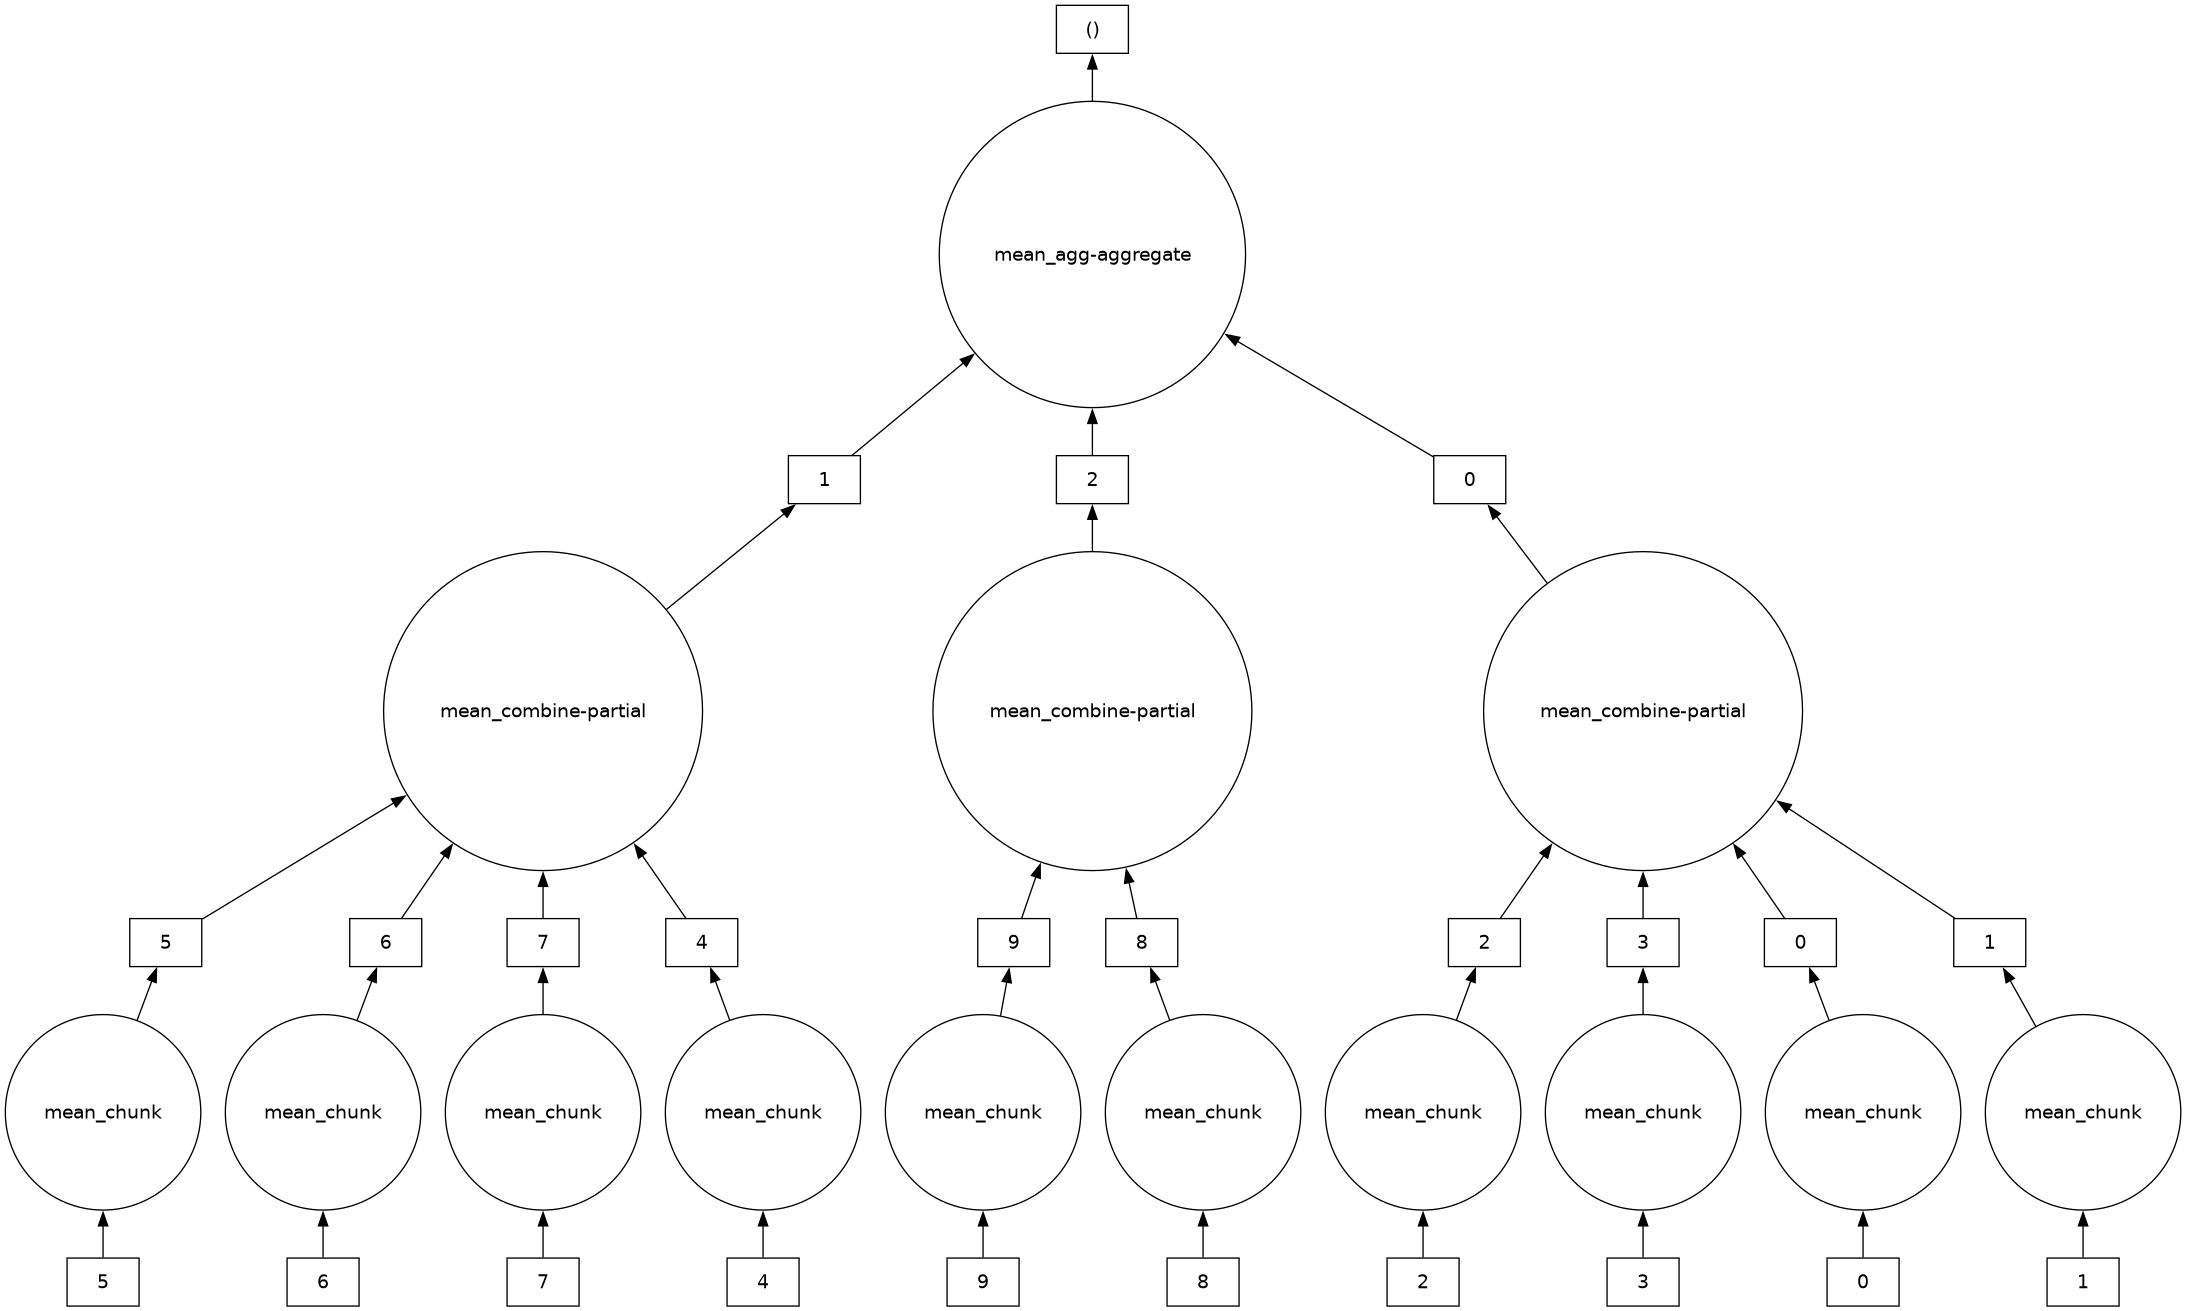

In [9]:
da_array.mean().visualize(engine="graphviz")

Let’s try a different operation: the square root.  
NumPy executes this in a single thread by default, so it won’t exploit all CPU cores.  
Dask, on the other hand, runs in **threaded mode** by default, which means it can use multiple threads to evaluate the computation graph in parallel.

In [10]:
da_array_op = da.sqrt(da_array).sum()

result = da_array_op.compute()
print(result)
%timeit da_array_op.compute()

6665398.634790414
12 ms ± 449 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


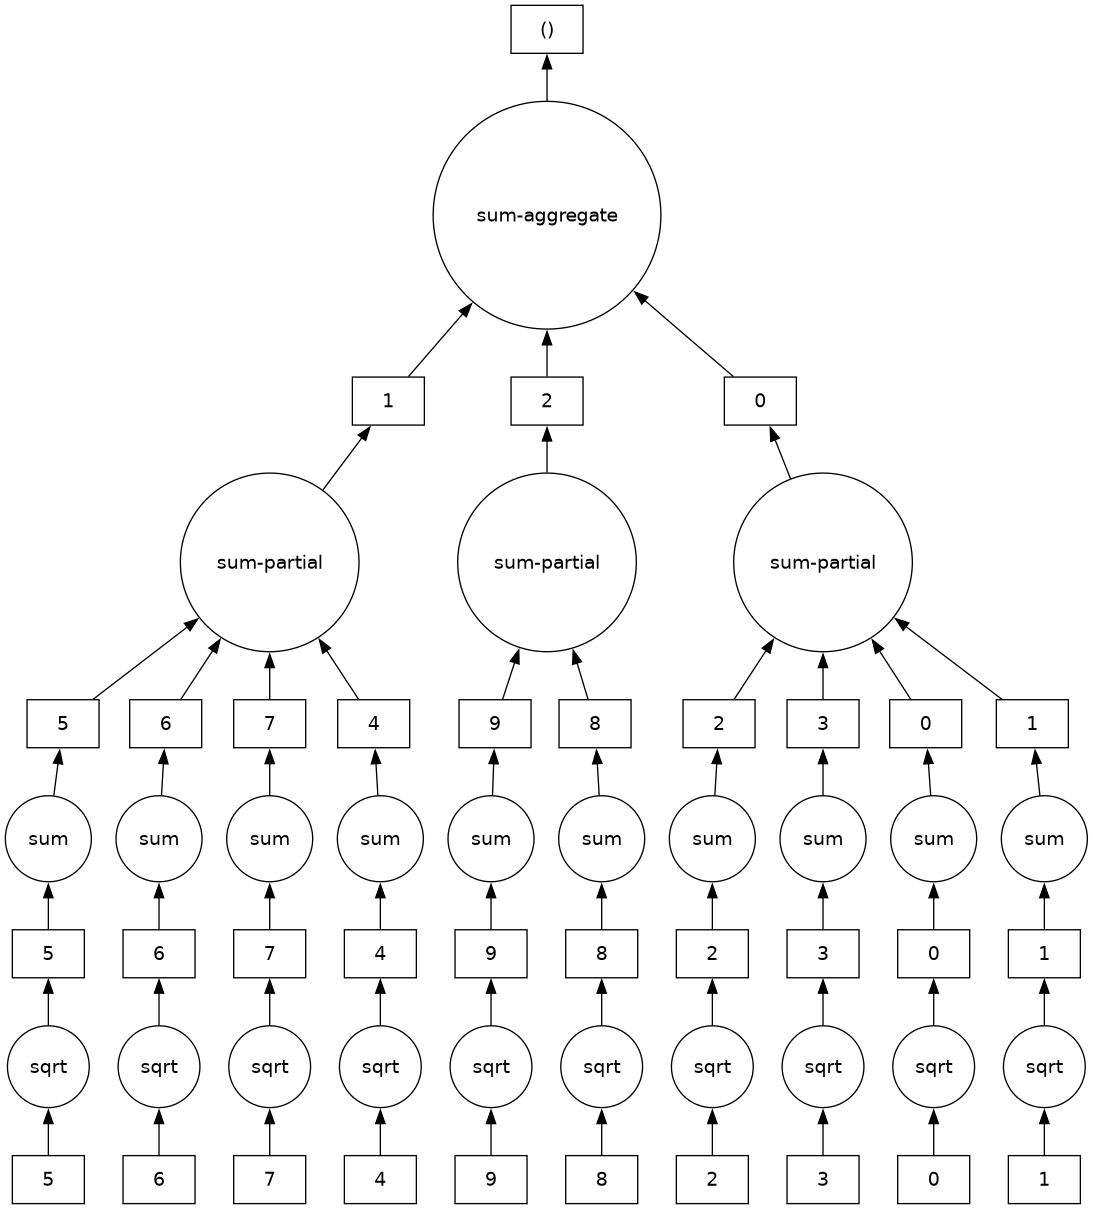

In [11]:
da_array_op.visualize()

In [12]:
result = np.sqrt(np_array).sum()
print(result)
%timeit np.sqrt(np_array).sum()

6665398.634790413
32.4 ms ± 153 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Task 1
Experiment with different **chunk sizes** and observe their impact on performance.  
How does the choice of chunking influence execution time?

```python
da_task1 = da.from_array(np_array, chunks=xxxxxxxxxx)
print(f"Chunk size {i}:  ", end="")
%timeit da.sqrt(da_task1).sum().compute()
```

In [15]:
#ToDo

31.3 s ± 413 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.05 s ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
347 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
43.9 ms ± 848 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Dask DataFrame and Dask Bag (quick look)

While our focus is on arrays and numerical computing, note that Dask has other collections:

* Dask DataFrame: Parallelizes pandas DataFrame operations across many partitions (useful for tabular data bigger than RAM or for leveraging multiple cores).
* Dask Bag: For general Python objects or irregular data (like a list of Python dicts, text processing, etc.), providing functional programming primitives to parallelize map, filter, etc.

If your HPC tasks involve big data tables or unstructured data, these might be relevant. Usage is similar: you create a Dask DataFrame by reading data (e.g., `dd.read_csv` or `dd.from_pandas`), then use familiar methods like `df.groupby().sum()`, and call `.compute()` to execute. Under the hood, it will do the grouping on each partition in parallel, then aggregate.

In [10]:
# Read multiple csv files
df = dd.read_csv(os.path.join('/shared-scratch/hpcp/nycflights/*.csv'),dtype={'TailNum': object, 'CRSElapsedTime': float, 'Cancelled': bool})
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [11]:
largest_delay = df[~df.Cancelled].DepDelay.max()
largest_delay

<dask_expr.expr.Scalar: expr=((Filter(frame=ArrowStringConversion(frame=FromMapProjectable(aa8e63a)), predicate=~ ArrowStringConversion(frame=FromMapProjectable(aa8e63a))['Cancelled']))['DepDelay']).max(), dtype=float64>

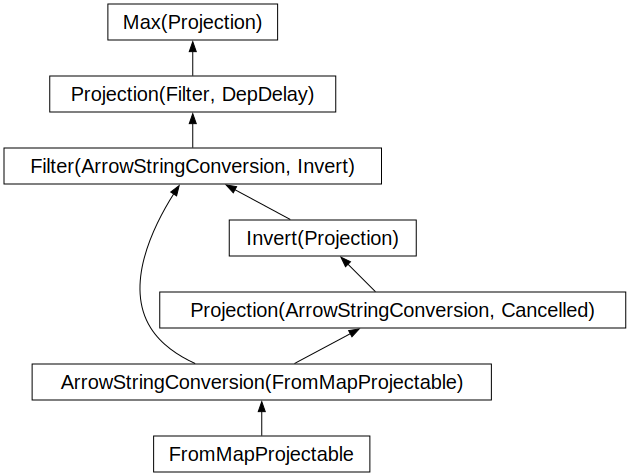

In [12]:
largest_delay.visualize()

In [13]:
largest_delay.compute()

1435.0

### Custom Workflows: Dask Delayed and Futures for Parallel Python
Sometimes you have custom Python code (not easily expressed as array or dataframe operations) that you want to parallelize. Dask provides lower-level primitives for this:

* dask.delayed: a decorator or function to turn a Python function call into a lazy task in a graph.
* dask.distributed Client submit/gather (Futures): to directly submit functions to the scheduler for asynchronous execution.

These allow you to express workflows that might not fit into the high-level collections.

Let's say we have an expensive function that processes a single piece of data (could be anything: an image, a simulation for one parameter set, etc.). We want to run it for many inputs in parallel.

Example scenario: We want to compute $f(x) = \sqrt{x^2 + 1}$ for a bunch of values of x (just a toy example). We could do this in a loop, but we'll simulate that f(x) is expensive (imagine it calls a heavy subroutine or does a big file I/O).

In [23]:
def f(x):
    # Simulate an expensive computation
    sleep(0.1)            # pretend there's a time-consuming step
    return math.sqrt(x**2 + 1)

# Suppose we want to compute this for 20 different values:
xs = list(range(20))
%time results = [f(x) for x in xs]
print(results)

CPU times: user 431 μs, sys: 1.03 ms, total: 1.46 ms
Wall time: 2 s
[1.0, 1.4142135623730951, 2.23606797749979, 3.1622776601683795, 4.123105625617661, 5.0990195135927845, 6.082762530298219, 7.0710678118654755, 8.06225774829855, 9.055385138137417, 10.04987562112089, 11.045361017187261, 12.041594578792296, 13.038404810405298, 14.035668847618199, 15.033296378372908, 16.0312195418814, 17.029386365926403, 18.027756377319946, 19.026297590440446]


In [26]:
# Convert the function calls into delayed tasks
tasks = [dask.delayed(f)(x) for x in xs]
print(tasks[:3])  # each element is a Delayed object, not a result

# Combine tasks (if needed). Here we just want all results, so we can use dask.delayed to gather them into a list
results_delayed = dask.delayed(list)(tasks)

%time results = results_delayed.compute()
print(results)

[Delayed('f-16978282-0e7f-46fb-bb7e-0455451208f0'), Delayed('f-24ac4d89-4a80-4653-a73e-e57d2c1a0980'), Delayed('f-73454375-4528-4928-9e20-db1598703f4e')]
CPU times: user 6.57 ms, sys: 94 μs, total: 6.66 ms
Wall time: 505 ms
[1.0, 1.4142135623730951, 2.23606797749979, 3.1622776601683795, 4.123105625617661, 5.0990195135927845, 6.082762530298219, 7.0710678118654755, 8.06225774829855, 9.055385138137417, 10.04987562112089, 11.045361017187261, 12.041594578792296, 13.038404810405298, 14.035668847618199, 15.033296378372908, 16.0312195418814, 17.029386365926403, 18.027756377319946, 19.026297590440446]


When you run this:

* Printing tasks will show something like Delayed('f-<uuid>'), ... – these are placeholders for the future results.
* The .compute() will execute f(x) for all x in parallel (using threads or processes via the Dask scheduler). The total time should be around ~0.1s (plus a bit of overhead) instead of 2s, because 20 tasks were executed concurrently on available cores. If you have, say, 4 cores, it might take ~0.5s (since tasks will run 4 at a time in threads).
* This demonstrates that Dask can parallelize a Python loop with minimal changes. We didn't have to write thread-handling or use concurrent futures directly; Dask handles it.

**Important**: If f(x) releases the GIL or is a pure Python function, using the threaded scheduler vs multiprocess scheduler could matter. sleep() releases the GIL, so threads are fine here. If the function was CPU-bound Python code not releasing GIL, Dask might use multiple processes to truly run in parallel. You can specify the scheduler or let Dask decide.

#### Task 2

Write a custom function (for example, one that uses a loop or does some I/O) and use dask.delayed to apply it to many inputs. Measure the speedup vs a normal Python loop. Try both the threaded scheduler and the multiprocess scheduler (hint: use `dask.config.set(scheduler='processes')` or `dask.compute(..., scheduler='processes')` for the computation) and see if there's a difference. Which scheduler works better for your function?

In [31]:
#ToDo

Thread scheduler
CPU times: user 22.7 s, sys: 105 ms, total: 22.8 s
Wall time: 22.7 s
Process scheduler
CPU times: user 8.37 ms, sys: 6.04 ms, total: 14.4 ms
Wall time: 13 s


### Distributed Client and Futures
When working in a distributed setting (multiple machines), it can be convenient to use the Dask Distributed Client API. This allows you to submit tasks directly to the cluster and get back futures, which are placeholders for results that you can query or wait on. It is somewhat analogous to `concurrent.futures` in Python but works across the cluster.

First, let's start a Dask LocalCluster. We use different TCP ports, in case we end up on the same compute node. 

In [7]:
dashboard_port=int(f"100{user_port}")
cluster_port=int(f"101{user_port}")

da_cluster = LocalCluster(scheduler_port=cluster_port, dashboard_address=f":{dashboard_port}")
client = Client(da_cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:10055/status,
Dashboard: http://127.0.0.1:10055/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:10155,Workers: 0
Dashboard: http://127.0.0.1:10055/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38769,Total threads: 1
Dashboard: http://127.0.0.1:43055/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:34627,


In [8]:
print("Use the following command to access your Dask dashboard. The cmd will create a port forwarding over SSH.")
print("You can then go to http://localhost:8787/status in your browser and see the dashboard.")
print()
print(f"ssh -L 8787:{socket.gethostname()}:100{user_port} {os.environ['USER']}@merlin-l-001")

Use the following command to access your Dask dashboard. The cmd will create a port forwarding over SSH.
You can then go to http://localhost:8787/status in your browser and see the dashboard.

ssh -L 8787:merlin-c-113.psi.ch:10055 ext-marcin_s@merlin-l-001


![SSH](img/ssh.png)

In [9]:
def g(x):
    # Another example function (simulate something complicated)
    import math
    return math.sin(x) ** 2

# Submit tasks to the Dask scheduler:
futures = [client.submit(g, x) for x in range(10)]
print(futures)         # list of Future objects

results = client.gather(futures)  # this will block until all are done and return results
print(results)

[<Future: pending, key: g-3eeb9f0b6992a8fadd225b4bf085f453>, <Future: pending, key: g-9887e3093f388588e49eaa7bb05a9f66>, <Future: pending, key: g-2ccca51347f94b5254ec6cea6d4aad64>, <Future: pending, key: g-a50387b1f1c4b89e0ab10a0d41366ad5>, <Future: pending, key: g-6543822f67221bd7a248e4c9d903ab10>, <Future: pending, key: g-f3526c0bfcb55c9a6fd6154d7f266eb9>, <Future: pending, key: g-0bacb39d646b208c8f506d692562c0b6>, <Future: pending, key: g-ef1e485ef022b3f3c073346bb4201290>, <Future: pending, key: g-4cf478fda1f2dc2c097abd9818887308>, <Future: pending, key: g-4e4718b6c51e396264b0342f900e9ef9>]
[0.0, 0.7080734182735712, 0.826821810431806, 0.01991485667481699, 0.5727500169043067, 0.9195357645382262, 0.07807302063375395, 0.43163139089608316, 0.9788297401616923, 0.16984164587795994]


You might wonder, what's the difference between using client.submit and dask.delayed? In practice:

* dask.delayed is great for building up a task graph with dependencies within your code, then computing once at the end (it's high-level).
* client.submit is more interactive/low-level, good for when you have a running cluster and want to fire off tasks ad-hoc (each submit is like sending a job to the scheduler).

You can mix them: e.g., convert a large delayed workflow into a single future by future = client.compute(delayed_obj) instead of .compute() (this gives you a future to track the ongoing computation without blocking the Python process).

For our purposes, you can use either approach. In many cases, the higher-level APIs (Dask Array, DataFrame) are even more convenient because they construct these graphs for you under the hood. But it's good to know you have this fine-grained control.

#### Task 3  

Re-run the earlier examples using both **Dask DataFrame** and **Dask Array**, then open the **Dask Scheduler / LocalCluster dashboard** to observe how the tasks are scheduled and executed.

In [14]:
# Shutdown of our LocalCluster
client.close()
da_cluster.close()

### Setting Up a Dask Cluster on an HPC (Slurm)



In [2]:
# Configure cluster parameters:
cluster = SLURMCluster(
    queue='hourly',        # your Slurm partition/queue name
    cores=4,               # total cores per job (across all processes in a job)
    processes=1,           # how many processes per job (if 1, then 4 threads in one process in this example)
    memory="10GB",         # memory per job
    walltime="00:30:00",   # time per job
    scheduler_options={'dashboard_address': f':100{user_port}'},
    job_extra_directives=["--reservation=sschool25"],  # (optional) extra Slurm sbatch directives, e.g., request 1 GPU per job
    #interface="ib0",
)
print(cluster.job_script()) 

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p hourly
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=10G
#SBATCH -t 00:30:00
#SBATCH --reservation=sschool25

/opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/bin/python -m distributed.cli.dask_worker tcp://129.129.185.63:32779 --name dummy-name --nthreads 4 --memory-limit 9.31GiB --nanny --death-timeout 60



Task exception was never retrieved
future: <Task finished name='Task-326476' coro=<Client._gather.<locals>.wait() done, defined at /opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-392809' coro=<Client._gather.<locals>.wait() done, defined at /opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit

Now, to actually launch workers, you decide how many you want. You can do this in two ways:

* Use `cluster.scale(n)` to start n worker jobs.
* Use `cluster.adapt(minimum=m, maximum=M)` to allow the cluster to autoscale between m and M workers depending on the workload.

In [29]:
cluster.scale(2)

This will submit 2 jobs to Slurm (you should see them in the squeue if you check, named "dask-worker"). Each job will start a Dask worker that connects to your scheduler. By default, the scheduler is running in the same Python process where you created the cluster (i.e., in your notebook).

In [20]:
!squeue -u ${USER}

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          27462056   general spawner- ext-marc  R    1:02:08      1 merlin-c-113
          27462869    hourly dask-wor ext-marc  R       0:37      1 merlin-c-224
          27462868    hourly dask-wor ext-marc  R       0:38      1 merlin-c-211


Finally, connect a client to this cluster. As before, the client object in a Jupyter notebook will show a rich output with the cluster status (how many workers, etc.) and a link to the dashboard. Now the difference is those workers live on separate cluster nodes! The client is now connected to a distributed Dask cluster spanning multiple nodes.

In [4]:
client = Client(cluster)
client

<Client: 'tcp://129.129.185.63:32779' processes=2 threads=8, memory=18.62 GiB>

In [6]:
# Give it a try and check out the dashboard
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = x + x.T
%time total = y.sum().compute()
print(total)

CPU times: user 1.32 s, sys: 120 ms, total: 1.44 s
Wall time: 37.7 s
100007316.28137685


How it works under the hood: When you call SLURMCluster(...), Dask-jobqueue actually creates a specification for the worker jobs. When you scale up, it uses Slurm (via sbatch or srun under the hood) to submit those jobs. Each job runs the dask-worker command to start a worker that connects back to your central scheduler. The scheduler is running in your notebook process (or a separate job if you choose, but in our case, it's on the login node). This pattern of one job for the scheduler + multiple jobs for workers is sometimes called a dynamic cluster deployment. It's great for interactive and exploratory work since you can quickly get workers and release them.

Another pattern (not covered in depth here) is a batch cluster deployment where you submit the entire Dask cluster (scheduler + workers + your script) as one big batch job (using dask-mpi or SLURMRunner). That is more static and suitable for a single large batch workload. In this tutorial, we focus on the dynamic approach because it's more flexible for a workshop setting.

In [21]:
@numba.njit
def count_inside(n):
    """Return number of points inside quarter circle out of n random points."""
    in_count = 0
    for i in range(n):
        x = random.random()
        y = random.random()
        if x*x + y*y <= 1.0:
            in_count += 1
    return in_count

# Now define a function to estimate pi with n points (monte carlo)
def estimate_pi(n):
    inside = count_inside(n)
    return 4.0 * inside / n

# We will run this function multiple times in parallel
trials = 20
points_per_trial = 10_000_000
tasks = [dask.delayed(estimate_pi)(points_per_trial) for _ in range(trials)]
avg_pi = (sum(tasks) / len(tasks)).persist()  # start the computation asynchronously
print("Computing pi with Dask distributed...")
pi_estimate = avg_pi.compute()
print("Estimated π =", pi_estimate)

Computing pi with Dask distributed...
Estimated π = 3.1416852000000004


A few things happening:

* We decorated the inner function with Numba `@njit` to make each trial faster (otherwise pure Python random in a loop would be slow).
* We use delayed to create trials number of tasks, each calling estimate_pi(points_per_trial).
* We then take the average of the results as another Dask task. Actually, we could have let Dask do the sum in parallel too. Here for simplicity, we sum the delayed objects (which makes a new delayed object) and divide by `len(tasks)`.
* We call `.persist()` on the final result instead of `.compute()` initially. `.persist()` will submit all tasks to the cluster and return a Dask collection that is actively computing (non-lazy). We then print a message and eventually call `.compute()` to get the final value. We could also just do `.compute()` straight away; persist is used here to possibly overlap with any other work (not strictly necessary).
* When you run this on the cluster with multiple workers, each worker should take on one or more of the trials. If you have 4 workers and 20 tasks, each might do 5 trials.
* Check the dashboard (particularly the "Progress" or "Graph" plots) to visualize all these tasks running.

#### Task 4 Adjust the Monte Carlo π estimation to:
* Not use Numba and see the effect (likely slower) or use NumPy only.
* Use more points per trial vs more trials – which is more effective to improve accuracy? Which is more pleasant for Dask (lots of small tasks vs fewer heavy tasks)?
* Push the cluster. Use `cluster.scale()` to scale up your workers. How many total samples can you generate per second with Dask?

In [ ]:
#ToDo

Another example: Large Array Computation (e.g., matrix operations)

Suppose we have to perform some linear algebra on very large matrices that do not fit in one node's memory. For instance, multiplying a 50k x 50k matrix with its transpose. A 50k x 50k matrix has 2.5 billion entries, which is way too many to actually materialize – this is just for illustration (actual memory would be tens of GBs). But we can do a smaller size that is still large, and use Dask's distributed memory.

Let's do a covariance-like computation on a large simulated dataset: say we have 100k samples of 1000 features, and we want to compute the covariance matrix (1000x1000). This involves an outer product of a (100k x 1000) matrix with its transpose (1000 x 100k). The result is 1000x1000, which is fine, but the intermediate multiplies are heavy.

We'll simulate this and use Dask:

In [22]:
# Simulate 100k x 1000 array of data in Dask (split by rows among workers)
samples = 100_000
features = 1000
# We'll chunk the rows so that each chunk maybe has 10k rows (so 10 chunks of shape 10k x 1000)
data = da.random.random(size=(samples, features), chunks=(10_000, features))
print(data)

# Compute covariance matrix = data^T @ data (assuming mean ~ 0 for simplicity)
cov = data.T.dot(data)  # 1000x1000 result, but this is a large operation under the hood
%time cov_result = cov.compute()
print(cov_result.shape)

dask.array<random_sample, shape=(100000, 1000), dtype=float64, chunksize=(10000, 1000), chunktype=numpy.ndarray>
CPU times: user 1.03 s, sys: 97.5 ms, total: 1.13 s
Wall time: 29.5 s
(1000, 1000)


### Loading Data Efficiently with Dask  

Up to this point, we’ve mostly worked with toy examples where we created data in memory (e.g. with NumPy) and then wrapped it in a Dask array.  
This approach works for small arrays, but it becomes inefficient for larger data. 

In [24]:
# Create a Dask array from the NumPy array, dividing it into chunks
N = 10_000_000
np_array = np.random.random(N)
chunk_size = 1_000_000
da_array = da.from_array(np_array, chunks=chunk_size)
da_mean = da_array.mean().compute()  # triggers computation
print(da_mean)

0.4999871025756871


/opt/psi/Programming/anaconda/2024.08/conda/envs/summer-school-hpc-2025/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 76.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Why does this happen?
When you pass an existing NumPy array into Dask (from_array), the full data object has to be communicated through the Dask scheduler.
This is fine for small arrays, but for truly large data it becomes a bottleneck. Ideally, the scheduler should only coordinate tasks, not shuffle gigabytes of raw data.

Best practice: Load the data directly with Dask (or libraries that support chunked storage) so that the data lives on disk and Dask only reads the necessary pieces on each worker.

For example, we can store a large dataset in an HDF5 file with chunking enabled:

In [30]:
N = 100_000_000
arr = np.random.random(N)

with h5py.File(f"/shared-scratch/hpcp/tmp/{os.environ["USER"]}_chunked.h5", "w") as f:
    dset = f.create_dataset(
        "100M_array",
        data=arr,
        chunks=(10000),      # each chunk is 1000
        compression="gzip"   # compress the data
    )

Later, instead of sending the full arr through the scheduler, we let Dask map to this on-disk dataset (using `da.from_array()`).
This way, each worker will load only the chunks it needs, avoiding unnecessary data transfer and making the computation far more scalable.

In [32]:
f = h5py.File(f"/shared-scratch/hpcp/tmp/{os.environ["USER"]}_chunked.h5")
x = da.from_array(f["100M_array"])
x.mean().compute()

np.float64(0.499992358777124)

#### Task 5
Efficient **chunking strategies** are critical for performance.  
Experiment with different chunk sizes across the examples in this notebook.  
Try scaling the cluster up and down, and also test **adaptive scaling** with `cluster.adapt(minimum=m, maximum=M)`.

The goal: build hands-on experience and develop an intuition for how Dask executes computations.

When you’re done, remember to **shut down the cluster** to free resources:

In [33]:
client.close()
cluster.close()